# Generate EKF C-code from Dynamic System Model

In [1]:
# Generate and Compile C Code
%run generate_ekf.py

import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)
importlib.reload(subprocess)

# Compile C code and create library

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Remove old library
subprocess.call('rm -f *.so', shell=True, cwd=path)
subprocess.call('rm -f *.o', shell=True, cwd=path)
# Compile object files
subprocess.call('gcc -fPIC -c *.c common/*.c -Icommon', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
# subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
lib = ctypes.CDLL(lib_path)

# define argument types 
lib.ekf_set_Q.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_R_mocap.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_R_vbody.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_X.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_P_diag.argtypes = [ctypes.POINTER(ctypes.c_float)]

lib.ekf_get_X.restype = ctypes.POINTER(ctypes.c_float)
lib.ekf_get_P.restype = ctypes.POINTER(ctypes.c_float)

lib.ekf_predict.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.c_float]
lib.ekf_update_mocap.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_update_vbody.argtypes = [ctypes.POINTER(ctypes.c_float)]

ekf_use_quat = ctypes.c_bool.in_dll(lib, "ekf_use_quat")
ekf_use_quat.value = True

PREDICTION:
CSE
SIMPLIFY
CCODE
S and PHT MATRICES FOR SOLVING K:
CSE
SIMPLIFY
CCODE
UPDATE:
CSE
SIMPLIFY
CCODE
S and PHT MATRICES FOR SOLVING K:
CSE
SIMPLIFY
CCODE
UPDATE:
CSE
SIMPLIFY
CCODE


# Test C code

In [136]:
import matplotlib.pyplot as plt
from analyze import *

#data = np.load('ekf_data_6may_8ms_delay.npz')
data = load_flight_data('flight_data/Okt10_NN_long_oval_2.csv')
data = trim_nn_active(data)
data = trim_time(data, 0, 10)

# optitrack frequency    
opti_updates =  [i for i in range(1,len(data['t'])) if ((data['x_opti'][i]!=data['x_opti'][i-1]) | (data['y_opti'][i]!=data['y_opti'][i-1]) | (data['z_opti'][i]!=data['z_opti'][i-1]))]

opti_freq = 1/np.mean(np.diff(data['t'][opti_updates]))
print('optitrack frequency:',opti_freq,'Hz')

animate_data_multiple(data)

Loading flight_data/Okt10_NN_long_oval_2.csv
Logging frequency: 808.4233029186809
optitrack frequency: 18.506752500448332 Hz


QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to tar

In [137]:
# equation from https://arxiv.org/pdf/2409.01080
# ar = omega_dot x r + omega x (omega x r)
from sympy import symbols, Matrix
rx, ry, rz = symbols('rx ry rz')
p, q, r = symbols('p q r')
dp, dq, dr = symbols('dp dq dr')
omega = Matrix([p, q, r])
omega_dot = Matrix([dp, dq, dr])
r = Matrix([rx, ry, rz])
rhs = omega_dot.cross(r) + omega.cross(omega.cross(r))
for ri in rhs:
    print(ri)

dq*rz - dr*ry + q*(p*ry - q*rx) - r*(-p*rz + r*rx)
-dp*rz + dr*rx - p*(p*ry - q*rx) + r*(q*rz - r*ry)
dp*ry - dq*rx + p*(-p*rz + r*rx) - q*(q*rz - r*ry)


k_x, rx, ry, rz: -4.4811234671267365e-05 -0.0027757065591940662 -0.02646569079458877 -0.0022195330098877734
k_x_est, k_xq_est, k_xr_est: -6.0106249749116174e-05 -0.07728425526667924 0.6293492878688185
k_x_old: -4.4101352886986136e-05
k_y_est, k_yp_est, k_yr_est: -5.314854835749677e-05 0.039971359116768836 0.054476984934980974
k_y_old: -5.637960835110806e-05


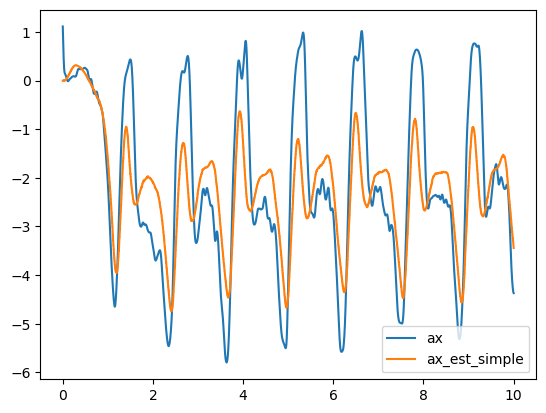

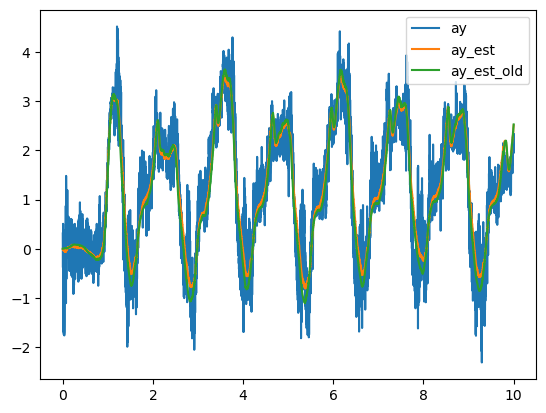

In [138]:
# fit_thrust_drag_model(data)

# we have a drag model for ax and ay
# ax = k_x * vbx *(omega[0] + omega[1] + omega[2] + omega[3])
# ay = k_y * vby *(omega[0] + omega[1] + omega[2] + omega[3])
# we can find k_x and k_y with linear regression
ax = data['ax']-data['ekf_acc_b_x']
ay = data['ay']-data['ekf_acc_b_y']
vbx = data['vbx']
vby = data['vby']
omega0, omega1, omega2, omega3 = data['omega[0]'], data['omega[1]'], data['omega[2]'], data['omega[3]']
p = data['p']
q = data['q']
r = data['r']
# derivative of gyro
dp = np.gradient(data['p'], data['t'])
dq = np.gradient(data['q'], data['t'])
dr = np.gradient(data['r'], data['t'])
# low pass butterworth filtfilt
import scipy.signal as signal
b, a = signal.butter(2, 0.02)
dp = signal.filtfilt(b, a, dp)
dq = signal.filtfilt(b, a, dq)
dr = signal.filtfilt(b, a, dr)

# new regression model
# ax = ax_drag + ax_r
# ax_r = dq*rz - dr*ry + q*(p*ry - q*rx) - r*(-p*rz + r*rx)
# ax_r = rx*(-q**2 - r**2) + ry*(p*q - dr) + rz*(p*r + dq)
X = np.stack([
    vbx*(omega0 + omega1 + omega2 + omega3), # drag model
    -q**2-r**2, # rx
    p*q-dr, # ry
    p*r+dq # rz
])
Y = ax
k_x, rx, ry, rz = A = np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_x, rx, ry, rz:', k_x, rx, ry, rz)
ax_est_gyro_effect = A@X


# new model
X = np.stack([vbx*(omega0 + omega1 + omega2 + omega3), q, r])
Y = ax
k_x_est, k_xq_est, k_xr_est, = A = np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_x_est, k_xq_est, k_xr_est:', k_x_est, k_xq_est, k_xr_est)
ax_est = A@X

# old
X = np.stack([vbx*(omega0 + omega1 + omega2 + omega3)])
Y = ax
k_x_old, = A= np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_x_old:', k_x_old)
ax_est_old = A@X

# new model
X = np.stack([vby*(omega0 + omega1 + omega2 + omega3), p, r])
Y = ay
k_y_est, k_yp_est, k_yr_est, = A = np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_y_est, k_yp_est, k_yr_est:', k_y_est, k_yp_est, k_yr_est)
ay_est = A@X

# old
X = np.stack([vby*(omega0 + omega1 + omega2 + omega3)])
Y = ay
k_y_old, = A= np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_y_old:', k_y_old)
ay_est_old = A@X

# simple
X = np.stack([vbx])
Y = ax
k_x_simple, = A= np.linalg.lstsq(X.T, Y, rcond=None)[0]
ax_est_simple = k_x_simple*vbx

X = np.stack([vby])
Y = ay
k_y_simple, = A= np.linalg.lstsq(X.T, Y, rcond=None)[0]
ay_est_simple = k_y_simple*vby

ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)

plt.plot(data['t'], ax_filt, label='ax')
# plt.plot(data['t'], ax_est, label='ax_est')
# plt.plot(data['t'], ax_est_old, label='ax_est_old')
# plt.plot(data['t'], ax_est_gyro_effect, label='ax_est_gyro_effect')
plt.plot(data['t'], ax_est_simple, label='ax_est_simple')
plt.legend()
plt.show()

plt.plot(data['t'], ay, label='ay')
plt.plot(data['t'], ay_est, label='ay_est')
plt.plot(data['t'], ay_est_old, label='ay_est_old')
plt.legend()
plt.show()

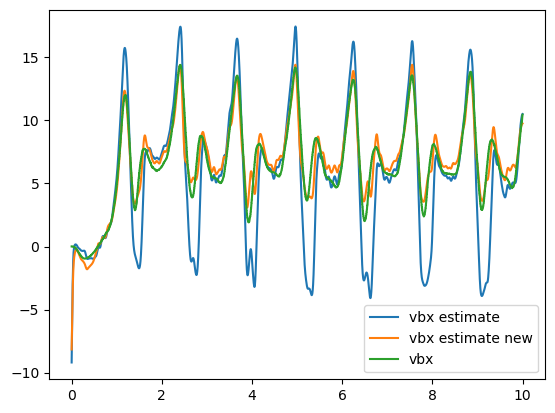

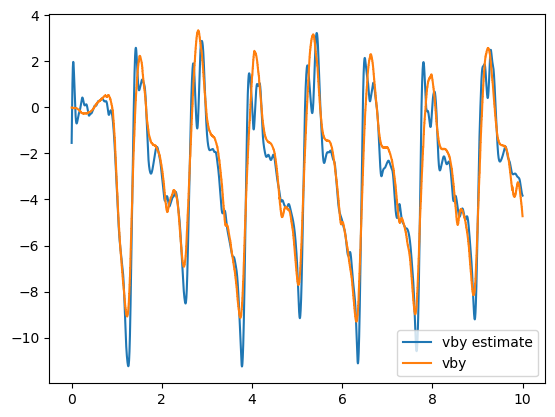

In [139]:
k_x = -4.41e-5
k_y = -5.64e-5
wsum = data['omega[0]']+data['omega[1]']+data['omega[2]']+data['omega[3]']
# ax = k_x*wsum*vbx --> vbx = ax/(k_x*wsum)
# ay = k_y*wsum*vby --> vby = ay/(k_y*wsum)
vbx_estimate = (data['ax']-data['ekf_acc_b_x'])/(k_x*wsum)
vby_estimate = (data['ay']-data['ekf_acc_b_y'])/(k_y*wsum)

# new equation
vbx_estimate_new = (data['ax']- k_xq_est*q - k_xr_est*r)/(k_x_est*wsum)
vby_estimate_new = (data['ay']- k_yp_est*p - k_yr_est*r)/(k_y_est*wsum)

data['vbx_estimate'] = vbx_estimate
data['vby_estimate'] = vby_estimate

data['vbx_estimate_new'] = vbx_estimate_new
data['vby_estimate_new'] = vby_estimate_new

vbx_est_filt = signal.filtfilt(b, a, vbx_estimate)
vby_est_filt = signal.filtfilt(b, a, vby_estimate)
vbx_est_new_filt = signal.filtfilt(b, a, vbx_estimate_new)
vby_est_new_filt = signal.filtfilt(b, a, vby_estimate_new)

plt.plot(data['t'], vbx_est_filt, label='vbx estimate')
plt.plot(data['t'], vbx_est_new_filt, label='vbx estimate new')
plt.plot(data['t'], data['vbx'], label='vbx')
plt.legend()
plt.show()

plt.plot(data['t'], vby_est_filt, label='vby estimate')
# plt.plot(data['t'], data['vby_estimate_new'], label='vby estimate new')
plt.plot(data['t'], data['vby'], label='vby')
plt.legend()
plt.show()

In [140]:
# EKF INPUT: U = [ax, ay, az, p, q, r] (IMU)
U_data = np.array([
    data['ax'], data['ay'], data['az'], data['p'], data['q'], data['r']
]).T

# EKF MEASUREMENT MOCAP: Z = [x, y, z, qw, qx, qy, qz] (Optitrack)
Z_data_mocap = np.array([
    data['x_opti'], data['y_opti'], data['z_opti'], data['qw_opti'], data['qx_opti'], data['qy_opti'], data['qz_opti']
]).T
# EKF MEASUREMENT VBODY Z = [vbx, vby]
Z_data_vbody = np.array([data['vbx_estimate_new'], data['vby_estimate_new']]).T
# Z_data_vbody = np.array([data['vbx'], data['vby']]).T

t = data['t']

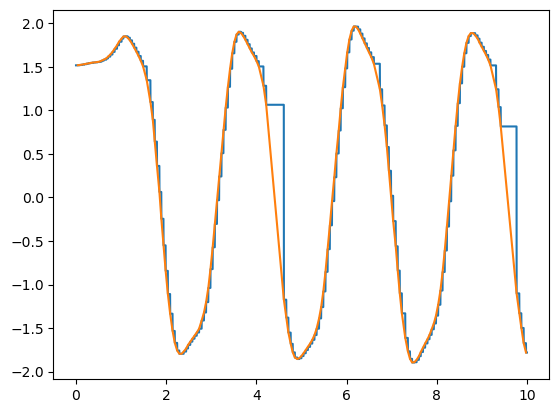

In [141]:
plt.plot(t, Z_data_mocap[:,0], label='x')
# add 0.2 gaussian noise to mocap measurements
# Z_data_mocap[:,0:3] += np.random.normal(0, 0.2, Z_data_mocap[:,0:3].shape)
plt.plot(t[opti_updates], Z_data_mocap[opti_updates,0], label='x')

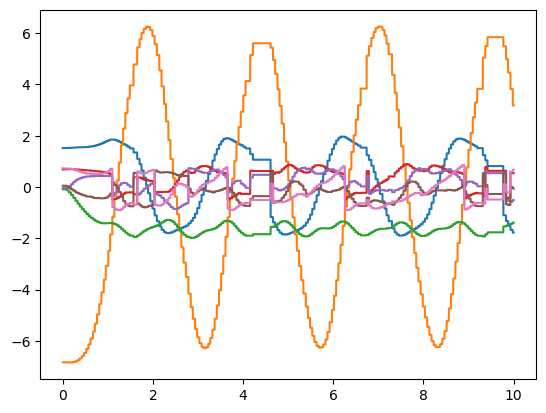

In [142]:
plt.plot(t, Z_data_mocap[:,0], label='x')
plt.plot(t, Z_data_mocap[:,1], label='y')
plt.plot(t, Z_data_mocap[:,2], label='z')
plt.plot(t, Z_data_mocap[:,3], label='qw')
plt.plot(t, Z_data_mocap[:,4], label='qx')
plt.plot(t, Z_data_mocap[:,5], label='qy')
plt.plot(t, Z_data_mocap[:,6], label='qz')

In [228]:
# INITIALIZE EKF
# initial state
lenX = 16
X_init = np.zeros(lenX)
X_init[:3] = Z_data_mocap[0,:3]
a = -72. * np.pi / 180.
X_init[6] = np.cos(0.5*a)
X_init[7] = 0.0
X_init[8] = 0.0
X_init[9] = np.sin(0.5*a)
X_init[6:10] = Z_data_mocap[0,3:7]
# X_init[12:15] = [p_bias, q_bias, r_bias]

# initial covariance
P_init = np.array([1.]*lenX)
#P_init[9] = 10. # initial heading covarinace
P_init[-6:-3] = 1e-2 # set accel bias covariance
P_init[-3:] = 0#1e-2 # set gyro bias covariance. 
# P_init[-3:] *= (ekf_use_quat.value) # do not estimate bias if no heading measurement
# print(P_init)

# process noise covariance
# Q_diag = np.array([0.5, 0.5, 0.5, 0.01, 0.01, 0.01, 1e-5, 1e-5, 1e-5, 0, 0, 0])
Q_diag = np.array([0.5, 0.5, 0.5, 0.001, 0.001, 0.001, 1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5])
Q_diag[-3:] *= (ekf_use_quat.value)

# measurement noise covariance MOCAP
R_diag_mocap = np.array([0.5, 0.5, 0.5, .0005, .0005, .0005, .0005])
# measurement noise covariance VBODY
R_diag_vbody = np.array([100000., 100000.])

lib.ekf_set_Q((ctypes.c_float*len(Q_diag))(*Q_diag))
lib.ekf_set_R_mocap((ctypes.c_float*len(R_diag_mocap))(*R_diag_mocap))
lib.ekf_set_R_vbody((ctypes.c_float*len(R_diag_vbody))(*R_diag_vbody))
lib.ekf_set_X((ctypes.c_float*len(X_init))(*X_init))
lib.ekf_set_P_diag((ctypes.c_float*len(P_init))(*P_init))

# test ekf_get_state
x = lib.ekf_get_X()
x = np.array([x[i] for i in range(lenX)])
print(x)

# RUN EKF
X_ekf = [X_init]
P_ekf = [np.array([1.])*int(lenX*(lenX+1)/2)]

X_sampled = []
X_delayed = []
X_shift =[]
m_idx =[]

# start with N mocap updates to converge more
# ekf_use_quat.value = True
# N = 100
# for i in range(N):
#     # update
#     lib.ekf_update_mocap(
#         (ctypes.c_float*len(Z_data_mocap[0]))(*Z_data_mocap[0])
#     )
ekf_use_quat.value = False

for i in range(1, len(t)):
    # PREDICT 
    U = np.zeros_like(U_data[i])

    # COMPUTE DRAG MODEL
    x = lib.ekf_get_X()
    x = np.array([x[i] for i in range(lenX)])
    x,y,z,vxw,vyw,vzw,qw,qx,qy,qz = x[:10]
    # get body velocity from world velocity v_body = q_world_to_body * v_world * q_world_to_body_conj
    quat_inv = np.array([qw,-qx,-qy,-qz])
    v_world = np.array([vxw,vyw,vzw])
    v_body = quadRotate(quat_inv, v_world)
    
    # Dx = -4.41e-05*v_body[0]*(omega0[i] + omega1[i] + omega2[i] + omega3[i])
    # Dy = -5.64e-05*v_body[1]*(omega0[i] + omega1[i] + omega2[i] + omega3[i])
    Dx = -0.4*v_body[0] #- 0.03*v_body[0]**2
    Dy = -0.5*v_body[1] #- 0.01*v_body[1]**2
    
    alpha = 1.0
    U[0] = (1-alpha)*U_data[i,0] + alpha*Dx
    U[1] = (1-alpha)*U_data[i,1] + alpha*Dy
    U[2:] = U_data[i,2:]
    
    
    lib.ekf_predict(
        (ctypes.c_float*len(U))(*U),
        ctypes.c_float(t[i]-t[i-1])
    )
    
    # UPDATE MOCAP
    # only update when there is a new measurement
    # if np.any(Z_data_mocap[i]-Z_data_mocap[i-1] != 0):
    # if i in opti_updates:
    #     m_idx.append(i)
    #     # update
    #     Z = Z_data_mocap[i].copy()
    #     if ekf_use_quat.value == False:
    #         Z[3:] = 0
    #     lib.ekf_update_mocap(
    #         (ctypes.c_float*len(Z_data_mocap[i]))(*Z_data_mocap[i])
    #     )
        
    # UPDATE VBODY
    # only update when there is a new measurement
    # if np.any(Z_data_vbody[i]-Z_data_vbody[i-1] != 0):
    #     # update
    #     lib.ekf_update_vbody(
    #         (ctypes.c_float*len(Z_data_vbody[i]))(*Z_data_vbody[i])
    #     )
        
    # get state
    x = lib.ekf_get_X()
    x = np.array([x[i] for i in range(lenX)])
    X_ekf.append(x)
    
    # get Pdiag
    P = lib.ekf_get_P()
    P = np.array([P[i] for i in range(int(lenX*(lenX+1)/2))])
    P_ekf.append(P)
    #print(P[[int(i*(i+1)/2 + i) for i in range(13,16)]])


[ 1.51699996 -6.83199978 -0.088       0.          0.          0.
  0.68377012 -0.03802141  0.05020303  0.72695953  0.          0.
  0.          0.          0.          0.        ]


In [229]:
X_ekf_corrected =  np.array(X_ekf)
X_ekf_normal = np.array(X_ekf)
X_ekf_Zshift = np.array(X_ekf)

Using matplotlib backend: module://matplotlib_inline.backend_inline


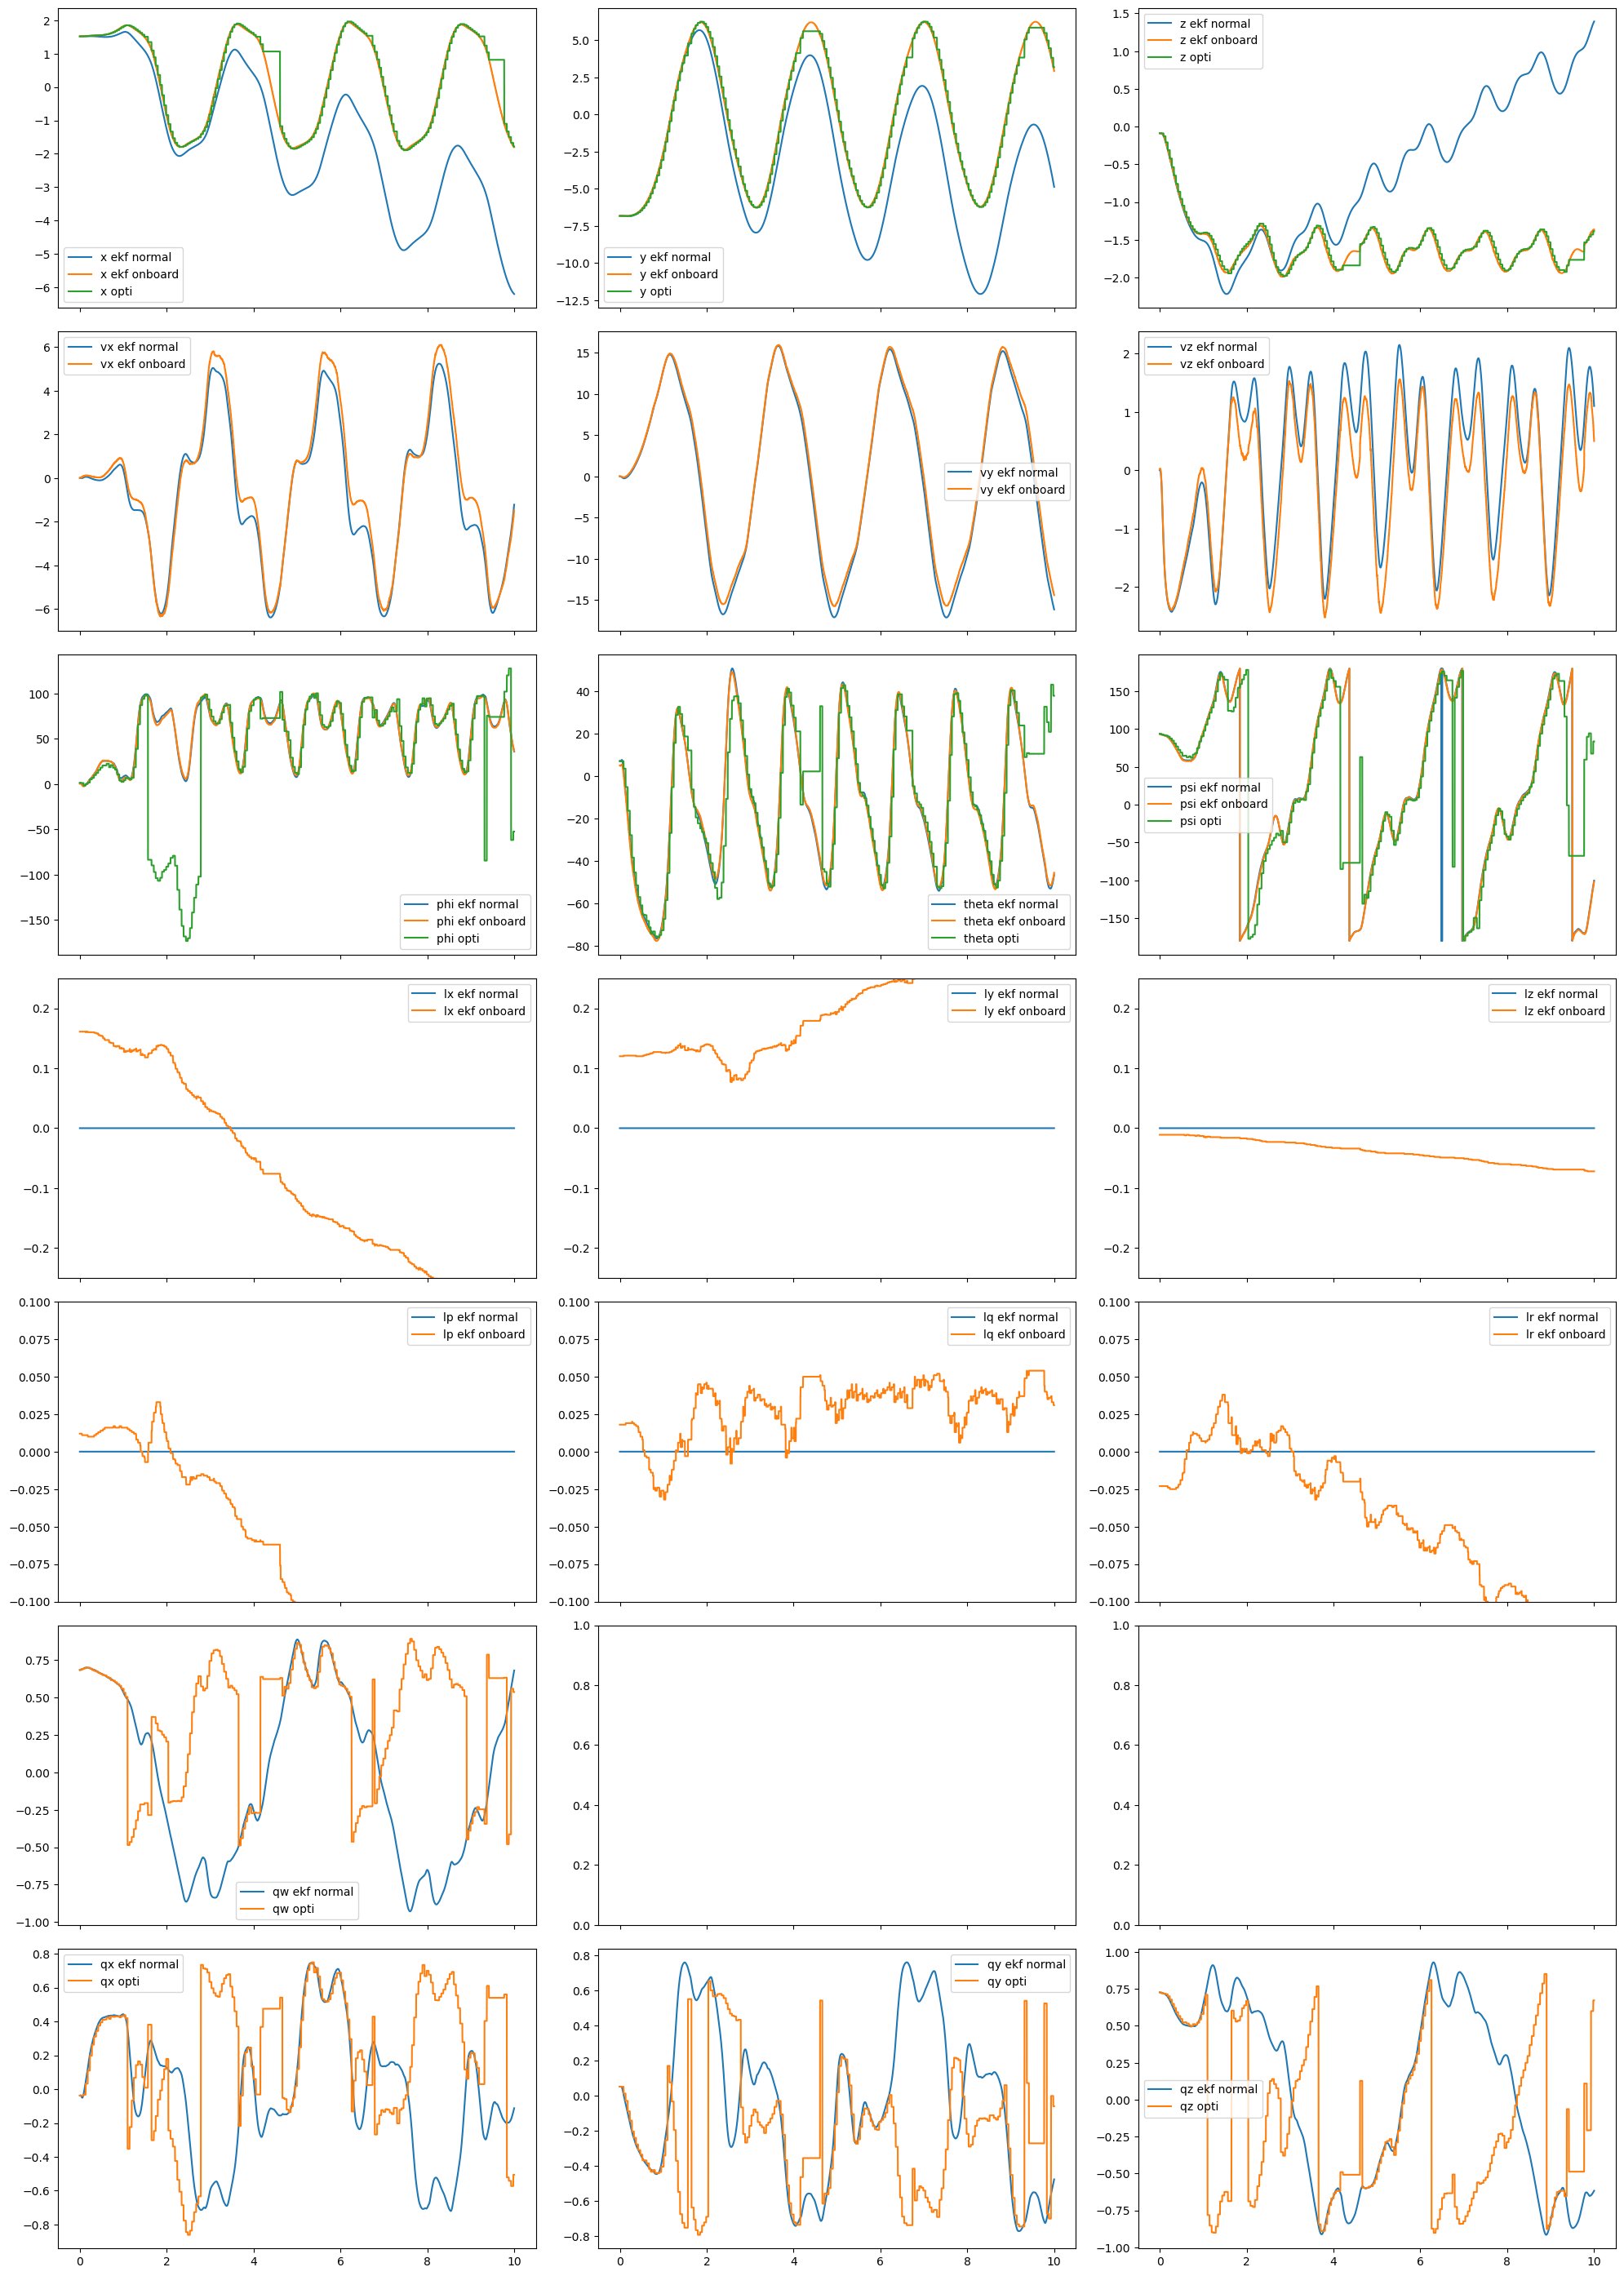

In [230]:
# plot trajectory
%matplotlib
X_ekf = np.array(X_ekf)
# Pdiag_ekf = np.array(Pdiag_ekf)


# 5x3 subplots
fig, axs = plt.subplots(7, 3, figsize=(20,7/5*20), tight_layout=True, sharex=True)
axs = axs.flatten()

# position
axs[0].plot(t, X_ekf_normal[:,0], label='x ekf normal')
# axs[0].plot(t, X_ekf_Zshift[:,0], label='x ekf Zshift')
# axs[0].plot(t, X_ekf_corrected[:,0], label='x ekf corrected')
axs[0].plot(t, data['ekf_x'], label='x ekf onboard')
axs[0].plot(t, data['x_opti'], label='x opti')
axs[0].legend()


axs[1].plot(t, X_ekf_normal[:,1], label='y ekf normal')
# axs[1].plot(t, X_ekf_Zshift[:,1], label='y ekf Zshift')
# axs[1].plot(t, X_ekf_corrected[:,1], label='y ekf corrected')
axs[1].plot(t, data['ekf_y'], label='y ekf onboard')
axs[1].plot(t, data['y_opti'], label='y opti')
axs[1].legend()

axs[2].plot(t, X_ekf_normal[:,2], label='z ekf normal')
# axs[2].plot(t, X_ekf_Zshift[:,2], label='z ekf Zshift')
# axs[2].plot(t, X_ekf_corrected[:,2], label='z ekf corrected')
axs[2].plot(t, data['ekf_z'], label='z ekf onboard')
axs[2].plot(t, data['z_opti'], label='z opti')
axs[2].legend()

# velocity
axs[3].plot(t, X_ekf_normal[:,3], label='vx ekf normal')
# axs[3].plot(t, X_ekf_Zshift[:,3], label='vx ekf Zshift')
# axs[3].plot(t, X_ekf_corrected[:,3], label='vx ekf corrected')
axs[3].plot(t, data['ekf_vx'], label='vx ekf onboard')
axs[3].legend()

axs[4].plot(t, X_ekf_normal[:,4], label='vy ekf normal')
# axs[4].plot(t, X_ekf_Zshift[:,4], label='vy ekf Zshift')
# axs[4].plot(t, X_ekf_corrected[:,4], label='vy ekf corrected')
axs[4].plot(t, data['ekf_vy'], label='vy ekf onboard')
axs[4].legend()

axs[5].plot(t, X_ekf_normal[:,5], label='vz ekf normal')
# axs[5].plot(t, X_ekf_Zshift[:,5], label='vz ekf Zshift')
# axs[5].plot(t, X_ekf_corrected[:,5], label='vz ekf corrected')
axs[5].plot(t, data['ekf_vz'], label='vz ekf onboard')
axs[5].legend()

# attitude
rad_to_deg = 180/np.pi
from scipy.spatial.transform import Rotation
eulers = Rotation.from_quat(X_ekf_normal[:, [7, 8, 9, 6]]).as_euler('xyz', degrees=False)
# eulers = np.zeros_like(X_ekf_normal[:, [6, 7, 8]])

axs[6].plot(t, rad_to_deg*eulers[:,0], label='phi ekf normal')
# axs[6].plot(t, rad_to_deg*X_ekf_Zshift[:,6], label='phi ekf Zshift')
# axs[6].plot(t, rad_to_deg*X_ekf_corrected[:,6], label='phi ekf corrected')
axs[6].plot(t, rad_to_deg*data['ekf_phi'], label='phi ekf onboard')
axs[6].plot(t, rad_to_deg*data['phi_opti'], label='phi opti')
axs[6].legend()

axs[7].plot(t, rad_to_deg*eulers[:,1], label='theta ekf normal')
# axs[7].plot(t, rad_to_deg*X_ekf_Zshift[:,7], label='theta ekf Zshift')
# axs[7].plot(t, rad_to_deg*X_ekf_corrected[:,7], label='theta ekf corrected')
axs[7].plot(t, rad_to_deg*data['ekf_theta'], label='theta ekf onboard')
axs[7].plot(t, rad_to_deg*data['theta_opti'], label='theta opti')
axs[7].legend()

axs[8].plot(t, rad_to_deg*eulers[:,2], label='psi ekf normal')
# axs[8].plot(t, rad_to_deg*X_ekf_Zshift[:,8], label='psi ekf Zshift')
# axs[8].plot(t, rad_to_deg*X_ekf_corrected[:,8], label='psi ekf corrected')
axs[8].plot(t, rad_to_deg*data['ekf_psi'], label='psi ekf onboard')
axs[8].plot(t, rad_to_deg*data['psi_opti'], label='psi opti')
axs[8].legend()

# biases
axs[9].plot(t, X_ekf_normal[:,10], label='lx ekf normal')
# axs[9].plot(t, X_ekf_Zshift[:,9], label='lx ekf Zshift')
# axs[9].plot(t, X_ekf_corrected[:,9], label='lx ekf corrected')
axs[9].plot(t, data['ekf_acc_b_x'], label='lx ekf onboard')
axs[9].set_ylim([-0.25, 0.25])
axs[9].legend()

axs[10].plot(t, X_ekf_normal[:,11], label='ly ekf normal')
# axs[10].plot(t, X_ekf_Zshift[:,10], label='ly ekf Zshift')
# axs[10].plot(t, X_ekf_corrected[:,10], label='ly ekf corrected')
axs[10].plot(t, data['ekf_acc_b_y'], label='ly ekf onboard')
axs[10].set_ylim([-0.25, 0.25])
axs[10].legend()

axs[11].plot(t, X_ekf_normal[:,12], label='lz ekf normal')
# axs[11].plot(t, X_ekf_Zshift[:,11], label='lz ekf Zshift')
# axs[11].plot(t, X_ekf_corrected[:,11], label='lz ekf corrected')
axs[11].plot(t, data['ekf_acc_b_z'], label='lz ekf onboard')
axs[11].set_ylim([-0.25, 0.25])
axs[11].legend()

axs[12].plot(t, rad_to_deg*X_ekf_normal[:,13], label='lp ekf normal')
# axs[12].plot(t, rad_to_deg*X_ekf_Zshift[:,12], label='lp ekf Zshift')
# axs[12].plot(t, rad_to_deg*X_ekf_corrected[:,12], label='lp ekf corrected')
axs[12].plot(t, rad_to_deg*data['ekf_gyro_b_x'], label='lp ekf onboard')
axs[12].set_ylim([-0.1, 0.1])
axs[12].legend()

axs[13].plot(t, rad_to_deg*X_ekf_normal[:,14], label='lq ekf normal')
# axs[13].plot(t, rad_to_deg*X_ekf_Zshift[:,13], label='lq ekf Zshift')
# axs[13].plot(t, rad_to_deg*X_ekf_corrected[:,13], label='lq ekf corrected')
axs[13].plot(t, rad_to_deg*data['ekf_gyro_b_y'], label='lq ekf onboard')
axs[13].set_ylim([-0.1, 0.1])
axs[13].legend()

axs[14].plot(t, rad_to_deg*X_ekf_normal[:,15], label='lr ekf normal')
# axs[14].plot(t, rad_to_deg*X_ekf_Zshift[:,14], label='lr ekf Zshift')
# axs[14].plot(t, rad_to_deg*X_ekf_corrected[:,14], label='lr ekf corrected')
axs[14].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='lr ekf onboard')
axs[14].set_ylim([-0.1, 0.1])
axs[14].legend()

axs[15].plot(t, X_ekf_normal[:,6], label='qw ekf normal')
#axs[15].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qw ekf onboard')
axs[15].plot(t, data['qw_opti'], label='qw opti')
axs[15].legend()

axs[18].plot(t, X_ekf_normal[:,7], label='qx ekf normal')
#axs[18].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qx ekf onboard')
axs[18].plot(t, data['qx_opti'], label='qx opti')
axs[18].legend()

axs[19].plot(t, X_ekf_normal[:,8], label='qy ekf normal')
#axs[19].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qy ekf onboard')
axs[19].plot(t, data['qy_opti'], label='qy opti')
axs[19].legend()

axs[20].plot(t, X_ekf_normal[:,9], label='qz ekf normal')
#axs[20].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qz ekf onboard')
axs[20].plot(t, data['qz_opti'], label='qz opti')
axs[20].legend()

plt.show()

In [231]:
pos_ekf = X_ekf[:,0:3]
pos_opti = np.array([data['x_opti'], data['y_opti'], data['z_opti']])
data2 = data.copy()
data2['x'] = X_ekf[:,0]
data2['y'] = X_ekf[:,1]
data2['z'] = X_ekf[:,2]

# gate_pos and gate_yaw
gate_pos = np.array([
    [1.5, -5., -1.5],
    [1.5,  5., -1.5],
    [0.0, 6.5, -1.5],
    [-1.5, 5., -1.5],
    [-1.5, -5., -1.5],
    [0.0, -6.5, -1.5]
])
gate_yaw = np.array([0, 0, 0.5, 1, 1, 1.5])*np.pi+np.pi/2
animate_data_multiple2(data2, gate_pos=gate_pos, gate_yaw=gate_yaw)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to target thread (0x6071a7c6c1a0)

QObject::moveToThread: Current thread (0x6071a7c6c1a0) is not the object's thread (0x6071a855b6b0).
Cannot move to tar

[0.00000000e+00 2.24849325e-07 1.93586223e-06 ... 8.33095507e+00
 8.34996398e+00 8.36901001e+00]


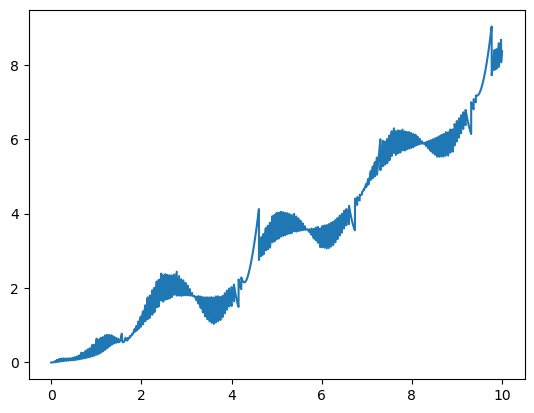

In [227]:
# plot difference between ekf and optitrack
diff = pos_ekf - pos_opti.T
diff_norm = np.linalg.norm(diff, axis=1)
print(diff_norm)
plt.plot(t, diff_norm)

array([0.0000000e+00, 1.2600000e-03, 2.5250000e-03, ..., 9.9977570e+00,
       9.9990160e+00, 1.0000276e+01])